In [3]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as tt
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

In [2]:
class ToDeviceLoader:
    def __init__(self,data,device):
        self.data = data
        self.device = device
        
    def __iter__(self):
        for batch in self.data:
            yield to_device(batch,self.device)
            
    def __len__(self):
        return len(self.data)
    
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

In [3]:
# HYPER_PARAMETER
NUM_CLASSES = 21
# DATA_DIR = "/home/qianq/mycodes/d2l-zh/pytorch/data/VOCdevkit/VOC2012"
device = get_device()
BATCH_SIZE = 8
# CROP_SIZE = (320, 480)
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
    

In [4]:
class DownBlock(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(DownBlock, self).__init__()
        self.block = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_dim),
            nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_dim))

    def forward(self, x):
        out = self.block(x)
        return out



class UpBlock(nn.Module):
    def __init__(self, in_dim, mid_dim, out_dim):
        super(UpBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_dim, mid_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(mid_dim),
            nn.Conv2d(mid_dim, mid_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(mid_dim),
            nn.ConvTranspose2d(mid_dim, out_dim, kernel_size=2, stride=2))

    def forward(self, x):
        out = self.block(x)
        return out


class UNet(nn.Module):
    def __init__(self, num_classes, in_dim=3, conv_dim=64):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.in_dim = in_dim
        self.conv_dim = conv_dim
        self.build_unet()

    def build_unet(self):
        self.enc1 = nn.Sequential(
            nn.Conv2d(self.in_dim, self.conv_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.conv_dim),
            nn.Conv2d(self.conv_dim, self.conv_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.conv_dim))
        self.enc2 = DownBlock(self.conv_dim, self.conv_dim*2)
        self.enc3 = DownBlock(self.conv_dim*2, self.conv_dim*4)
        self.enc4 = DownBlock(self.conv_dim*4, self.conv_dim*8)

        self.dec1 = UpBlock(self.conv_dim*8, self.conv_dim*16, self.conv_dim*8)
        self.dec2 = UpBlock(self.conv_dim*16, self.conv_dim*8, self.conv_dim*4)
        self.dec3 = UpBlock(self.conv_dim*8, self.conv_dim*4, self.conv_dim*2)
        self.dec4 = UpBlock(self.conv_dim*4, self.conv_dim*2, self.conv_dim)

        self.last = nn.Sequential(
            nn.Conv2d(self.conv_dim*2, self.conv_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.conv_dim),
            nn.Conv2d(self.conv_dim, self.conv_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.conv_dim),
            nn.Conv2d(self.conv_dim, self.num_classes, kernel_size=1, stride=1))

    def forward(self, x):
        enc1 = self.enc1(x) # 16
        enc2 = self.enc2(enc1) # 8
        enc3 = self.enc3(enc2) # 4
        enc4 = self.enc4(enc3) # 2

        center = nn.MaxPool2d(kernel_size=2, stride=2)(enc4)

        dec1 = self.dec1(center) # 4
        dec2 = self.dec2(torch.cat([enc4, dec1], dim=1))
        dec3 = self.dec3(torch.cat([enc3, dec2], dim=1))
        dec4 = self.dec4(torch.cat([enc2, dec3], dim=1))

        last = self.last(torch.cat([enc1, dec4], dim=1))
        assert x.size(-1) == last.size(-1), 'input size(W)-{} mismatches with output size(W)-{}' \
                                            .format(x.size(-1), last.size(-1))
        assert x.size(-2) == last.size(-2), 'input size(H)-{} mismatches with output size(H)-{}' \
                                            .format(x.size(-1), last.size(-1))
        return last

In [13]:
class AverageMeter:
    ''' Computes and stores the average and current value '''

    def __init__(self) -> None:
        self.reset()

    def reset(self) -> None:
        self.val = 0.0
        self.avg = 0.0
        self.sum = 0.0
        self.count = 0

    def update(self, val: float, n: int = 1) -> None:
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def get_dataloader_workers():
    """Use 4 processes to read the data."""
    return 4


def load_data_voc(batch_size, crop_size):
    """Load the VOC semantic segmentation dataset.

    Defined in :numref:`sec_semantic_segmentation`"""
    voc_dir = DATA_DIR
    num_workers = get_dataloader_workers()
    train_iter = DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers,
    )
    test_iter = DataLoader(
        VOCSegDataset(False, crop_size, voc_dir),
        batch_size,
        drop_last=True, num_workers=num_workers,
    )
    return train_iter, test_iter


# def loss(inputs, targets):
#     return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)


def accuracy(y_hat, y):
    """Compute the number of correct predictions.[each pixel]

    Defined in :numref:`sec_softmax_scratch`"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)
    cmp = astype(y_hat, y.dtype) == y
    size = 1
    for s in cmp.shape:
        size *= s
    return float(cmp.sum()/size)



def iou(pred, target, n_classes = 37):
    #n_classes ：the number of classes in your dataset
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)

    # Ignore IoU for background class ("0")
    for cls in range(1, n_classes):  # This goes from 1:n_classes-1 -> class "0" is ignored
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).long().sum().data.cpu()[0]  # Cast to long to prevent overflows
        union = pred_inds.long().sum().data.cpu()[0] + target_inds.long().sum().data.cpu()[0] - intersection
        if union == 0:
            ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
        else:
            ious.append(float(intersection) / float(max(union, 1)))
    return np.array(ious)


In [ ]:
class Lits17LiverDataset(Dataset):
    """
    A customized dataset to load the Lits dataset.
    Liver Segmentation Label.
    """

    def __init__(self, is_train, crop_size, voc_dir):
        self.train_transform = tt.Compose([
            
            tt.ToTensor(),
        ])
        self.crop_size = crop_size
        features, labels = self.read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = self.voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    @classmethod
    def normalize_image(cls, img):
        return cls.normalize_transform(img.float() / 255)

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = self.voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, self.voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

In [7]:
train_iter, test_iter = load_data_voc(BATCH_SIZE, CROP_SIZE)
train_dl = ToDeviceLoader(train_iter, device)
test_dl = ToDeviceLoader(test_iter, device)

read 1114 examples
read 1078 examples


In [8]:
model = UNet(num_classes=NUM_CLASSES)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, LEARNING_RATE, eta_min=0)
# lr_scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, LEARNING_RATE, total_iters=NUM_EPOCHS)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=LEARNING_RATE, epochs=NUM_EPOCHS, steps_per_epoch=len(train_dl)+1)

In [9]:
def train(train_iter, model, criterion, optimizer, epoch, total_epochs, lr_scheduler):
    loss_metric = AverageMeter()
    acc_metric = AverageMeter()
    num_steps = len(train_iter)
    lr_rate = lr_scheduler.get_last_lr()
    pbar = tqdm(total=num_steps)
    pbar.set_description(f"[Train] EPOCH [{epoch}/{total_epochs}], lr=[{lr_rate}]:")
    for i, (x, y) in enumerate(train_iter):
        batch_cnt = x.shape[0]
        model.train()
        optimizer.zero_grad()
        pred = model(x)
        l = criterion(pred, y)
        l.sum().backward()
        train_loss_sum = l.sum()
        train_acc_sum = accuracy(pred, y)
        optimizer.step()
        lr_scheduler.step()
        loss_metric.update(float(train_loss_sum), n=batch_cnt)
        acc_metric.update(train_acc_sum, n=1)
        pbar.update(1)
        pbar.set_postfix(loss=loss_metric.avg, acc=acc_metric.avg)
    return loss_metric.avg, acc_metric.avg


def valid(test_iter, model, criterion, epoch, total_epochs):
    loss_metric = AverageMeter()
    acc_metric = AverageMeter()
    num_steps = len(test_iter)
    lr_rate = lr_scheduler.get_last_lr()
    pbar = tqdm(total=num_steps)
    pbar.set_description(f"[Valid] EPOCH [{epoch}/{total_epochs}], lr=[{lr_rate}]:")
    for i, (x, y) in enumerate(test_iter):
        batch_cnt = x.shape[0]
        model.eval()
        pred = model(x)
        l = criterion(pred, y)
        train_loss_sum = l.sum()
        train_acc_sum = accuracy(pred, y)
        loss_metric.update(float(train_loss_sum), n=batch_cnt)
        acc_metric.update(train_acc_sum, n=1)
        pbar.update(1)
        pbar.set_postfix(loss=loss_metric.avg, acc=acc_metric.avg)
    return loss_metric.avg, acc_metric.avg
    

In [10]:
history = []
for epoch in range(1, NUM_EPOCHS+1):
    print('-' * 50)
    train_loss, train_acc = train(train_dl, model, criterion, optimizer, epoch, NUM_EPOCHS, lr_scheduler)
    lr_scheduler.step()
    valid_loss, valid_acc = valid(test_dl, model, criterion, epoch, NUM_EPOCHS)
    history.append([epoch, train_loss, train_acc, valid_loss, valid_acc])

--------------------------------------------------


[Train] EPOCH [1/100], lr=[[4.000000000000002e-06]]:: 100%|██████████| 139/139 [00:34<00:00,  4.02it/s, acc=0.155, loss=3.14]
[Valid] EPOCH [1/100], lr=[[4.2630741663332e-06]]:: 100%|██████████| 134/134 [00:14<00:00,  9.50it/s, acc=0.243, loss=3.12]


--------------------------------------------------


[Train] EPOCH [2/100], lr=[[4.2630741663332e-06]]:: 100%|██████████| 139/139 [00:34<00:00,  4.08it/s, acc=0.303, loss=3.02]
[Valid] EPOCH [2/100], lr=[[5.049412997958137e-06]]:: 100%|██████████| 134/134 [00:14<00:00,  9.50it/s, acc=0.369, loss=3]   


--------------------------------------------------


[Train] EPOCH [3/100], lr=[[5.049412997958137e-06]]:: 100%|██████████| 139/139 [00:34<00:00,  4.08it/s, acc=0.42, loss=2.85] 
[Valid] EPOCH [3/100], lr=[[6.350397101850431e-06]]:: 100%|██████████| 134/134 [00:14<00:00,  9.46it/s, acc=0.469, loss=2.88]


--------------------------------------------------


[Train] EPOCH [4/100], lr=[[6.350397101850431e-06]]:: 100%|██████████| 139/139 [00:34<00:00,  4.08it/s, acc=0.504, loss=2.73]
[Valid] EPOCH [4/100], lr=[[8.151765840154053e-06]]:: 100%|██████████| 134/134 [00:14<00:00,  9.48it/s, acc=0.537, loss=2.6] 


--------------------------------------------------


[Train] EPOCH [5/100], lr=[[8.151765840154053e-06]]:: 100%|██████████| 139/139 [00:34<00:00,  4.09it/s, acc=0.554, loss=2.63]
[Valid] EPOCH [5/100], lr=[[1.0433773647073704e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.47it/s, acc=0.552, loss=2.72]


--------------------------------------------------


[Train] EPOCH [6/100], lr=[[1.0433773647073704e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.08it/s, acc=0.582, loss=2.57]
[Valid] EPOCH [6/100], lr=[[1.3171406468385561e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.50it/s, acc=0.589, loss=2.67]


--------------------------------------------------


[Train] EPOCH [7/100], lr=[[1.3171406468385561e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.09it/s, acc=0.603, loss=2.52]
[Valid] EPOCH [7/100], lr=[[1.6334655951081602e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.48it/s, acc=0.61, loss=2.43] 


--------------------------------------------------


[Train] EPOCH [8/100], lr=[[1.6334655951081602e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.08it/s, acc=0.62, loss=2.46] 
[Valid] EPOCH [8/100], lr=[[1.9888848377638292e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.45it/s, acc=0.595, loss=2.82]


--------------------------------------------------


[Train] EPOCH [9/100], lr=[[1.9888848377638292e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.08it/s, acc=0.637, loss=2.39]
[Valid] EPOCH [9/100], lr=[[2.3795024739322148e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.42it/s, acc=0.645, loss=2.39]


--------------------------------------------------


[Train] EPOCH [10/100], lr=[[2.3795024739322148e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.08it/s, acc=0.654, loss=2.32]
[Valid] EPOCH [10/100], lr=[[2.8010367782387306e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.43it/s, acc=0.679, loss=2.16]


--------------------------------------------------


[Train] EPOCH [11/100], lr=[[2.8010367782387306e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.665, loss=2.28]
[Valid] EPOCH [11/100], lr=[[3.2488671346131144e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.49it/s, acc=0.66, loss=2.46] 


--------------------------------------------------


[Train] EPOCH [12/100], lr=[[3.2488671346131144e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.08it/s, acc=0.676, loss=2.2] 
[Valid] EPOCH [12/100], lr=[[3.718084684819455e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.46it/s, acc=0.64, loss=2.82] 


--------------------------------------------------


[Train] EPOCH [13/100], lr=[[3.718084684819455e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.686, loss=2.14]
[Valid] EPOCH [13/100], lr=[[4.203546136530695e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.44it/s, acc=0.623, loss=3.12]


--------------------------------------------------


[Train] EPOCH [14/100], lr=[[4.203546136530695e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.08it/s, acc=0.693, loss=2.06]
[Valid] EPOCH [14/100], lr=[[4.699930141134502e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.46it/s, acc=0.698, loss=1.99]


--------------------------------------------------


[Train] EPOCH [15/100], lr=[[4.699930141134502e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.08it/s, acc=0.699, loss=1.97]
[Valid] EPOCH [15/100], lr=[[5.201795623289535e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.43it/s, acc=0.721, loss=1.71]


--------------------------------------------------


[Train] EPOCH [16/100], lr=[[5.201795623289535e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.08it/s, acc=0.703, loss=1.89]
[Valid] EPOCH [16/100], lr=[[5.703641422857072e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.39it/s, acc=0.684, loss=2.23]


--------------------------------------------------


[Train] EPOCH [17/100], lr=[[5.703641422857072e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.707, loss=1.84]
[Valid] EPOCH [17/100], lr=[[6.199966595447566e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.47it/s, acc=0.703, loss=2.08]


--------------------------------------------------


[Train] EPOCH [18/100], lr=[[6.199966595447566e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.08it/s, acc=0.713, loss=1.74]
[Valid] EPOCH [18/100], lr=[[6.685330710602292e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.44it/s, acc=0.702, loss=1.96]


--------------------------------------------------


[Train] EPOCH [19/100], lr=[[6.685330710602292e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.713, loss=1.69]
[Valid] EPOCH [19/100], lr=[[7.154413486656153e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.46it/s, acc=0.695, loss=2.21]


--------------------------------------------------


[Train] EPOCH [20/100], lr=[[7.154413486656153e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.718, loss=1.61]
[Valid] EPOCH [20/100], lr=[[7.602073108598662e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.45it/s, acc=0.721, loss=1.47]


--------------------------------------------------


[Train] EPOCH [21/100], lr=[[7.602073108598662e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.718, loss=1.59]
[Valid] EPOCH [21/100], lr=[[8.02340258968634e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.45it/s, acc=0.724, loss=1.56]


--------------------------------------------------


[Train] EPOCH [22/100], lr=[[8.02340258968634e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.723, loss=1.51]
[Valid] EPOCH [22/100], lr=[[8.413783559002984e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.45it/s, acc=0.721, loss=1.78]


--------------------------------------------------


[Train] EPOCH [23/100], lr=[[8.413783559002984e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.726, loss=1.43]
[Valid] EPOCH [23/100], lr=[[8.768936885379628e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.43it/s, acc=0.714, loss=1.88]


--------------------------------------------------


[Train] EPOCH [24/100], lr=[[8.768936885379628e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.729, loss=1.37]
[Valid] EPOCH [24/100], lr=[[9.084969582763895e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.44it/s, acc=0.715, loss=1.94]


--------------------------------------------------


[Train] EPOCH [25/100], lr=[[9.084969582763895e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.729, loss=1.34]
[Valid] EPOCH [25/100], lr=[[9.358417482889186e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.44it/s, acc=0.729, loss=1.45]


--------------------------------------------------


[Train] EPOCH [26/100], lr=[[9.358417482889186e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.08it/s, acc=0.728, loss=1.34]
[Valid] EPOCH [26/100], lr=[[9.586283207490455e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.39it/s, acc=0.73, loss=1.37] 


--------------------------------------------------


[Train] EPOCH [27/100], lr=[[9.586283207490455e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.732, loss=1.26]
[Valid] EPOCH [27/100], lr=[[9.766069023837065e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.43it/s, acc=0.717, loss=1.6] 


--------------------------------------------------


[Train] EPOCH [28/100], lr=[[9.766069023837065e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.733, loss=1.23]
[Valid] EPOCH [28/100], lr=[[9.895804223439267e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.44it/s, acc=0.734, loss=1.26]


--------------------------------------------------


[Train] EPOCH [29/100], lr=[[9.895804223439267e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.735, loss=1.18]
[Valid] EPOCH [29/100], lr=[[9.974066723818753e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.46it/s, acc=0.731, loss=1.46]


--------------------------------------------------


[Train] EPOCH [30/100], lr=[[9.974066723818753e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.735, loss=1.17]
[Valid] EPOCH [30/100], lr=[[9.999999743087128e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.44it/s, acc=0.715, loss=1.81]


--------------------------------------------------


[Train] EPOCH [31/100], lr=[[9.999999743087128e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.08it/s, acc=0.735, loss=1.15]
[Valid] EPOCH [31/100], lr=[[9.994893184734316e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.41it/s, acc=0.736, loss=1.27]


--------------------------------------------------


[Train] EPOCH [32/100], lr=[[9.994893184734316e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.742, loss=1.08]
[Valid] EPOCH [32/100], lr=[[9.979727616518303e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.43it/s, acc=0.73, loss=1.27] 


--------------------------------------------------


[Train] EPOCH [33/100], lr=[[9.979727616518303e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.741, loss=1.08]
[Valid] EPOCH [33/100], lr=[[9.954533579875206e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.41it/s, acc=0.739, loss=1.12]


--------------------------------------------------


[Train] EPOCH [34/100], lr=[[9.954533579875206e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.741, loss=1.07]
[Valid] EPOCH [34/100], lr=[[9.919361812241932e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.44it/s, acc=0.726, loss=1.18]


--------------------------------------------------


[Train] EPOCH [35/100], lr=[[9.919361812241932e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.741, loss=1.07]
[Valid] EPOCH [35/100], lr=[[9.874283144877747e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.44it/s, acc=0.736, loss=1.36]


--------------------------------------------------


[Train] EPOCH [36/100], lr=[[9.874283144877747e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.741, loss=1.07]
[Valid] EPOCH [36/100], lr=[[9.819388360219535e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.39it/s, acc=0.742, loss=1.08]


--------------------------------------------------


[Train] EPOCH [37/100], lr=[[9.819388360219535e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.741, loss=1.07]
[Valid] EPOCH [37/100], lr=[[9.754788009058052e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.43it/s, acc=0.725, loss=1.22]


--------------------------------------------------


[Train] EPOCH [38/100], lr=[[9.754788009058052e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.742, loss=1.05]
[Valid] EPOCH [38/100], lr=[[9.680612187903354e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.41it/s, acc=0.736, loss=1.07]


--------------------------------------------------


[Train] EPOCH [39/100], lr=[[9.680612187903354e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.747, loss=0.998]
[Valid] EPOCH [39/100], lr=[[9.597010276987734e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.40it/s, acc=0.741, loss=1.1] 


--------------------------------------------------


[Train] EPOCH [40/100], lr=[[9.597010276987734e-05]]:: 100%|██████████| 139/139 [00:36<00:00,  3.76it/s, acc=0.747, loss=0.989]
[Valid] EPOCH [40/100], lr=[[9.504150639433815e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.41it/s, acc=0.736, loss=1.1] 


--------------------------------------------------


[Train] EPOCH [41/100], lr=[[9.504150639433815e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.752, loss=0.963]
[Valid] EPOCH [41/100], lr=[[9.402220282193624e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.45it/s, acc=0.742, loss=1.1] 


--------------------------------------------------


[Train] EPOCH [42/100], lr=[[9.402220282193624e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.752, loss=0.954]
[Valid] EPOCH [42/100], lr=[[9.291424479441481e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.40it/s, acc=0.741, loss=1.06]


--------------------------------------------------


[Train] EPOCH [43/100], lr=[[9.291424479441481e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.753, loss=0.946]
[Valid] EPOCH [43/100], lr=[[9.171986359179137e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.41it/s, acc=0.739, loss=1.02]


--------------------------------------------------


[Train] EPOCH [44/100], lr=[[9.171986359179137e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.05it/s, acc=0.756, loss=0.928]
[Valid] EPOCH [44/100], lr=[[9.044146453885657e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.44it/s, acc=0.734, loss=1.09]


--------------------------------------------------


[Train] EPOCH [45/100], lr=[[9.044146453885657e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.01it/s, acc=0.756, loss=0.923]
[Valid] EPOCH [45/100], lr=[[8.908162216117034e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.40it/s, acc=0.74, loss=1.03] 


--------------------------------------------------


[Train] EPOCH [46/100], lr=[[8.908162216117034e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.756, loss=0.919]
[Valid] EPOCH [46/100], lr=[[8.764307500030993e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.42it/s, acc=0.744, loss=0.996]


--------------------------------------------------


[Train] EPOCH [47/100], lr=[[8.764307500030993e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.758, loss=0.911]
[Valid] EPOCH [47/100], lr=[[8.612872009881167e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.40it/s, acc=0.739, loss=1.02] 


--------------------------------------------------


[Train] EPOCH [48/100], lr=[[8.612872009881167e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.763, loss=0.876]
[Valid] EPOCH [48/100], lr=[[8.454160716591286e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.43it/s, acc=0.738, loss=1.02] 


--------------------------------------------------


[Train] EPOCH [49/100], lr=[[8.454160716591286e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.765, loss=0.854]
[Valid] EPOCH [49/100], lr=[[8.288493243584319e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.40it/s, acc=0.738, loss=1.03]


--------------------------------------------------


[Train] EPOCH [50/100], lr=[[8.288493243584319e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.766, loss=0.856]
[Valid] EPOCH [50/100], lr=[[8.116203223103436e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.42it/s, acc=0.731, loss=1.07]


--------------------------------------------------


[Train] EPOCH [51/100], lr=[[8.116203223103436e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.767, loss=0.841]
[Valid] EPOCH [51/100], lr=[[7.937637624321082e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.40it/s, acc=0.748, loss=1]    


--------------------------------------------------


[Train] EPOCH [52/100], lr=[[7.937637624321082e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.772, loss=0.816]
[Valid] EPOCH [52/100], lr=[[7.753156054589221e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.47it/s, acc=0.747, loss=1.02] 


--------------------------------------------------


[Train] EPOCH [53/100], lr=[[7.753156054589221e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.777, loss=0.803]
[Valid] EPOCH [53/100], lr=[[7.563130035238003e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.42it/s, acc=0.74, loss=1.04] 


--------------------------------------------------


[Train] EPOCH [54/100], lr=[[7.563130035238003e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.78, loss=0.774] 
[Valid] EPOCH [54/100], lr=[[7.367942253381239e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.42it/s, acc=0.744, loss=1.06]


--------------------------------------------------


[Train] EPOCH [55/100], lr=[[7.367942253381239e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.781, loss=0.778]
[Valid] EPOCH [55/100], lr=[[7.167985791235483e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.40it/s, acc=0.741, loss=1.03]


--------------------------------------------------


[Train] EPOCH [56/100], lr=[[7.167985791235483e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.782, loss=0.773]
[Valid] EPOCH [56/100], lr=[[6.963663334504768e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.41it/s, acc=0.74, loss=1.06] 


--------------------------------------------------


[Train] EPOCH [57/100], lr=[[6.963663334504768e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.787, loss=0.745]
[Valid] EPOCH [57/100], lr=[[6.755386361425179e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.40it/s, acc=0.744, loss=1.02] 


--------------------------------------------------


[Train] EPOCH [58/100], lr=[[6.755386361425179e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.792, loss=0.713]
[Valid] EPOCH [58/100], lr=[[6.543574314102449e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.40it/s, acc=0.742, loss=1.01] 


--------------------------------------------------


[Train] EPOCH [59/100], lr=[[6.543574314102449e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.799, loss=0.693]
[Valid] EPOCH [59/100], lr=[[6.328653753811384e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.38it/s, acc=0.736, loss=1.07]


--------------------------------------------------


[Train] EPOCH [60/100], lr=[[6.328653753811384e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.8, loss=0.684]  
[Valid] EPOCH [60/100], lr=[[6.111057501958215e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.38it/s, acc=0.732, loss=1.08]


--------------------------------------------------


[Train] EPOCH [61/100], lr=[[6.111057501958215e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.809, loss=0.647]
[Valid] EPOCH [61/100], lr=[[5.8912237684358944e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.39it/s, acc=0.741, loss=1.02]


--------------------------------------------------


[Train] EPOCH [62/100], lr=[[5.8912237684358944e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.811, loss=0.64] 
[Valid] EPOCH [62/100], lr=[[5.669595269127685e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.40it/s, acc=0.741, loss=1.05]


--------------------------------------------------


[Train] EPOCH [63/100], lr=[[5.669595269127685e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.05it/s, acc=0.817, loss=0.611]
[Valid] EPOCH [63/100], lr=[[5.44661833433629e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.36it/s, acc=0.742, loss=1.04]


--------------------------------------------------


[Train] EPOCH [64/100], lr=[[5.44661833433629e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.823, loss=0.59] 
[Valid] EPOCH [64/100], lr=[[5.222742009934023e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.41it/s, acc=0.736, loss=1.08]


--------------------------------------------------


[Train] EPOCH [65/100], lr=[[5.222742009934023e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.05it/s, acc=0.828, loss=0.562]
[Valid] EPOCH [65/100], lr=[[4.9984171530441795e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.40it/s, acc=0.746, loss=1.01] 


--------------------------------------------------


[Train] EPOCH [66/100], lr=[[4.9984171530441795e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.833, loss=0.554]
[Valid] EPOCH [66/100], lr=[[4.774095524074792e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.37it/s, acc=0.738, loss=1.02] 


--------------------------------------------------


[Train] EPOCH [67/100], lr=[[4.774095524074792e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.839, loss=0.518]
[Valid] EPOCH [67/100], lr=[[4.550228876933297e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.41it/s, acc=0.739, loss=1.09]


--------------------------------------------------


[Train] EPOCH [68/100], lr=[[4.550228876933297e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.05it/s, acc=0.846, loss=0.5]  
[Valid] EPOCH [68/100], lr=[[4.327268049254271e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.37it/s, acc=0.741, loss=1.04]


--------------------------------------------------


[Train] EPOCH [69/100], lr=[[4.327268049254271e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.846, loss=0.491]
[Valid] EPOCH [69/100], lr=[[4.10566205447245e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.38it/s, acc=0.733, loss=1.07]


--------------------------------------------------


[Train] EPOCH [70/100], lr=[[4.10566205447245e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.857, loss=0.463]
[Valid] EPOCH [70/100], lr=[[3.8858571775694126e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.40it/s, acc=0.735, loss=1.09]


--------------------------------------------------


[Train] EPOCH [71/100], lr=[[3.8858571775694126e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.859, loss=0.452]
[Valid] EPOCH [71/100], lr=[[3.6682960763150344e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.42it/s, acc=0.744, loss=1.05]


--------------------------------------------------


[Train] EPOCH [72/100], lr=[[3.6682960763150344e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.868, loss=0.422]
[Valid] EPOCH [72/100], lr=[[3.4534168898136354e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.43it/s, acc=0.747, loss=1.03]


--------------------------------------------------


[Train] EPOCH [73/100], lr=[[3.4534168898136354e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.87, loss=0.416] 
[Valid] EPOCH [73/100], lr=[[3.2416523561501434e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.38it/s, acc=0.742, loss=1.04]


--------------------------------------------------


[Train] EPOCH [74/100], lr=[[3.2416523561501434e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.873, loss=0.404]
[Valid] EPOCH [74/100], lr=[[3.0334289409131755e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.38it/s, acc=0.738, loss=1.1] 


--------------------------------------------------


[Train] EPOCH [75/100], lr=[[3.0334289409131755e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.881, loss=0.382]
[Valid] EPOCH [75/100], lr=[[2.829165978350101e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.38it/s, acc=0.747, loss=1.04]


--------------------------------------------------


[Train] EPOCH [76/100], lr=[[2.829165978350101e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.887, loss=0.359]
[Valid] EPOCH [76/100], lr=[[2.6292748268836678e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.41it/s, acc=0.75, loss=1.05] 


--------------------------------------------------


[Train] EPOCH [77/100], lr=[[2.6292748268836678e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.08it/s, acc=0.889, loss=0.353]
[Valid] EPOCH [77/100], lr=[[2.4341580406908895e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.42it/s, acc=0.747, loss=1.07]


--------------------------------------------------


[Train] EPOCH [78/100], lr=[[2.4341580406908895e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.891, loss=0.347]
[Valid] EPOCH [78/100], lr=[[2.244208559012504e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.40it/s, acc=0.746, loss=1.05]


--------------------------------------------------


[Train] EPOCH [79/100], lr=[[2.244208559012504e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.895, loss=0.335]
[Valid] EPOCH [79/100], lr=[[2.0598089148256348e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.41it/s, acc=0.745, loss=1.06]


--------------------------------------------------


[Train] EPOCH [80/100], lr=[[2.0598089148256348e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.05it/s, acc=0.9, loss=0.321]  
[Valid] EPOCH [80/100], lr=[[1.8813304644732846e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.38it/s, acc=0.745, loss=1.09]


--------------------------------------------------


[Train] EPOCH [81/100], lr=[[1.8813304644732846e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.903, loss=0.312]
[Valid] EPOCH [81/100], lr=[[1.7091326398020827e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.40it/s, acc=0.752, loss=1.04]


--------------------------------------------------


[Train] EPOCH [82/100], lr=[[1.7091326398020827e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.909, loss=0.299]
[Valid] EPOCH [82/100], lr=[[1.543562224314376e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.42it/s, acc=0.746, loss=1.07]


--------------------------------------------------


[Train] EPOCH [83/100], lr=[[1.543562224314376e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.91, loss=0.297] 
[Valid] EPOCH [83/100], lr=[[1.3849526547924115e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.39it/s, acc=0.751, loss=1.06]


--------------------------------------------------


[Train] EPOCH [84/100], lr=[[1.3849526547924115e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.914, loss=0.285]
[Valid] EPOCH [84/100], lr=[[1.233623349801028e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.37it/s, acc=0.749, loss=1.08]


--------------------------------------------------


[Train] EPOCH [85/100], lr=[[1.233623349801028e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.916, loss=0.282]
[Valid] EPOCH [85/100], lr=[[1.0898790664211754e-05]]:: 100%|██████████| 134/134 [00:14<00:00,  9.40it/s, acc=0.747, loss=1.09]


--------------------------------------------------


[Train] EPOCH [86/100], lr=[[1.0898790664211754e-05]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.919, loss=0.273]
[Valid] EPOCH [86/100], lr=[[9.540092865097145e-06]]:: 100%|██████████| 134/134 [00:14<00:00,  9.39it/s, acc=0.747, loss=1.08]


--------------------------------------------------


[Train] EPOCH [87/100], lr=[[9.540092865097145e-06]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.92, loss=0.272] 
[Valid] EPOCH [87/100], lr=[[8.262876337214793e-06]]:: 100%|██████████| 134/134 [00:14<00:00,  9.40it/s, acc=0.749, loss=1.07]


--------------------------------------------------


[Train] EPOCH [88/100], lr=[[8.262876337214793e-06]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.921, loss=0.267]
[Valid] EPOCH [88/100], lr=[[7.0697132246765235e-06]]:: 100%|██████████| 134/134 [00:14<00:00,  9.37it/s, acc=0.747, loss=1.08]


--------------------------------------------------


[Train] EPOCH [89/100], lr=[[7.0697132246765235e-06]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.922, loss=0.261]
[Valid] EPOCH [89/100], lr=[[5.963006399201691e-06]]:: 100%|██████████| 134/134 [00:14<00:00,  9.41it/s, acc=0.748, loss=1.07]


--------------------------------------------------


[Train] EPOCH [90/100], lr=[[5.963006399201691e-06]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.927, loss=0.251]
[Valid] EPOCH [90/100], lr=[[4.9449846210533556e-06]]:: 100%|██████████| 134/134 [00:14<00:00,  9.36it/s, acc=0.752, loss=1.08]


--------------------------------------------------


[Train] EPOCH [91/100], lr=[[4.9449846210533556e-06]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.929, loss=0.246]
[Valid] EPOCH [91/100], lr=[[4.017698050611692e-06]]:: 100%|██████████| 134/134 [00:14<00:00,  9.38it/s, acc=0.752, loss=1.09]


--------------------------------------------------


[Train] EPOCH [92/100], lr=[[4.017698050611692e-06]]:: 100%|██████████| 139/139 [00:34<00:00,  4.05it/s, acc=0.928, loss=0.248]
[Valid] EPOCH [92/100], lr=[[3.1830141196238367e-06]]:: 100%|██████████| 134/134 [00:14<00:00,  9.37it/s, acc=0.748, loss=1.09]


--------------------------------------------------


[Train] EPOCH [93/100], lr=[[3.1830141196238367e-06]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.929, loss=0.246]
[Valid] EPOCH [93/100], lr=[[2.442613770444865e-06]]:: 100%|██████████| 134/134 [00:14<00:00,  9.38it/s, acc=0.744, loss=1.09]


--------------------------------------------------


[Train] EPOCH [94/100], lr=[[2.442613770444865e-06]]:: 100%|██████████| 139/139 [00:34<00:00,  4.03it/s, acc=0.929, loss=0.246]
[Valid] EPOCH [94/100], lr=[[1.7979880708436045e-06]]:: 100%|██████████| 134/134 [00:14<00:00,  9.28it/s, acc=0.751, loss=1.08]


--------------------------------------------------


[Train] EPOCH [95/100], lr=[[1.7979880708436045e-06]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.929, loss=0.241]
[Valid] EPOCH [95/100], lr=[[1.2504352111905545e-06]]:: 100%|██████████| 134/134 [00:14<00:00,  9.39it/s, acc=0.745, loss=1.09]


--------------------------------------------------


[Train] EPOCH [96/100], lr=[[1.2504352111905545e-06]]:: 100%|██████████| 139/139 [00:34<00:00,  4.05it/s, acc=0.932, loss=0.239]
[Valid] EPOCH [96/100], lr=[[8.01057890075297e-07]]:: 100%|██████████| 134/134 [00:14<00:00,  9.36it/s, acc=0.75, loss=1.09] 


--------------------------------------------------


[Train] EPOCH [97/100], lr=[[8.01057890075297e-07]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.932, loss=0.238]
[Valid] EPOCH [97/100], lr=[[4.507610936182366e-07]]:: 100%|██████████| 134/134 [00:14<00:00,  9.38it/s, acc=0.749, loss=1.08]


--------------------------------------------------


[Train] EPOCH [98/100], lr=[[4.507610936182366e-07]]:: 100%|██████████| 139/139 [00:34<00:00,  4.07it/s, acc=0.928, loss=0.247]
[Valid] EPOCH [98/100], lr=[[2.0025027294901817e-07]]:: 100%|██████████| 134/134 [00:14<00:00,  9.39it/s, acc=0.75, loss=1.09] 


--------------------------------------------------


[Train] EPOCH [99/100], lr=[[2.0025027294901817e-07]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.93, loss=0.245] 
[Valid] EPOCH [99/100], lr=[[5.002992352183303e-08]]:: 100%|██████████| 134/134 [00:14<00:00,  9.40it/s, acc=0.754, loss=1.1] 


--------------------------------------------------


[Train] EPOCH [100/100], lr=[[5.002992352183303e-08]]:: 100%|██████████| 139/139 [00:34<00:00,  4.06it/s, acc=0.931, loss=0.239]
[Valid] EPOCH [100/100], lr=[[4.02569128708331e-10]]:: 100%|██████████| 134/134 [00:14<00:00,  9.38it/s, acc=0.75, loss=1.08] 


In [11]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images.

    Defined in :numref:`sec_fashion_mnist`"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

/home/qianq/mycodes/d2l-zh/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/qianq/mycodes/d2l-zh/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/qianq/mycodes/d2l-zh/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/qianq/mycodes/d2l-zh/venv/lib/python3.11/site-packages/IPython/core/

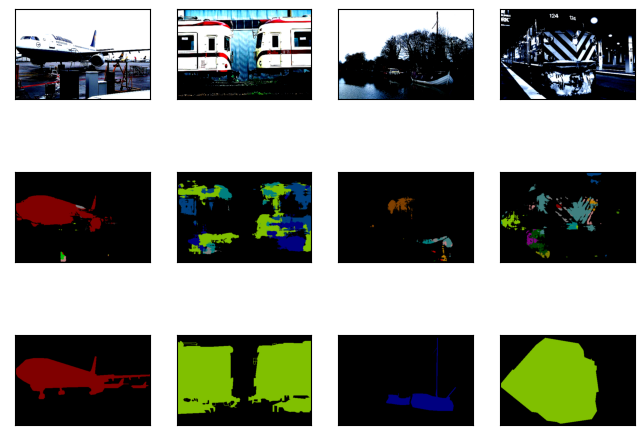

In [12]:
n, imgs = 4, []
index, (X, Y) = next(enumerate(test_iter))

X = X[:n].to('cuda:0')
y_hat = model(X).argmax(dim=1)

for i in range(n):
    x = X[i].permute(1,2,0).to('cpu')
    pred = VOCSegDataset.label2image(y_hat[i], device).to('cpu')
    y = VOCSegDataset.label2image(Y[i], device).to('cpu')
    imgs += [x, pred, y]

show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2)